In [6]:
import keras
import numpy as np
from scipy import stats
import pandas as pd
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Dense, Input, add, Activation, Flatten, AveragePooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model, Input
from keras.models import load_model
from keras.utils import multi_gpu_model
import time
from focal_loss_LSR import focal_loss
from keras.callbacks import EarlyStopping

CLASS_NUM          = 10



from keras import backend as K
# set GPU memory 
if('tensorflow' == K.backend()):
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    x_val = x_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    x_train = x_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    x_test = x_test[mask]
    y_test = y_test[mask]

    return x_train, y_train, x_val, y_val, x_test, y_test


def color_preprocessing(x_train,x_test,x_val):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_val = x_val.astype('float32')
    mean = [125.3, 123.0, 113.9]
    std  = [63.0,  62.1,  66.7]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
        x_val[:,:,:,i] = (x_val[:,:,:,i] - mean[i]) / std[i]

    return x_train, x_test, x_val


def all_np(arr):
    arr = np.array(arr)
    key = np.unique(arr)
    result = {}
    for k in key:
        mask = (arr == k)
        arr_new = arr[mask]
        v = arr_new.size
        result[k] = v
    return result




if __name__ == '__main__':

    # load data
    # (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()
    print('Train data shape: ', x_train.shape)
    print('Train labels shape: ', y_train.shape)
    print('Validation data shape: ', x_val.shape)
    print('Validation labels shape: ', y_val.shape)
    print('Test data shape: ', x_test.shape)
    print('Test labels shape: ', y_test.shape)
    
    classes_num = []
    s = all_np(y_train)
    for i in range(len(s)):
        classes_num.append(s[i])
    print(classes_num)   
    y_val1 = np.squeeze(y_val)
    x_val1 = x_val
    y_train = keras.utils.to_categorical(y_train, CLASS_NUM)
    y_val = keras.utils.to_categorical(y_val, CLASS_NUM)
    y_test = keras.utils.to_categorical(y_test, CLASS_NUM)
    
    # color preprocessing
    x_train, x_test, x_val = color_preprocessing(x_train, x_test, x_val)

    # build network
    resnet = load_model('wresnet6.h5')
    densenet = load_model('densenet.h5')
    print(resnet.summary())
    print(densenet.summary())
   
    sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    resnet.compile(optimizer=sgd, loss=[focal_loss(classes_num)], metrics=['accuracy'])   
    densenet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Predict labels with models
    dense1_layer_model = Model(inputs=resnet.input,
                                         outputs=resnet.get_layer('dense_1').output)
    dense2_layer_model = Model(inputs=densenet.input,
                                         outputs=densenet.get_layer('dense_1').output)
    dense1_output = dense1_layer_model.predict(x_val)
    dense2_output = dense2_layer_model.predict(x_val)
    renpin = 0.5
    ams = (renpin)*dense1_output+(1-renpin)*dense2_output
    predicts = np.argmax(ams, axis=1)
    error = np.sum(np.not_equal(predicts, y_val1)) / y_val1.shape[0] 
    print('The error : ', error)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)
[4913, 4881, 4921, 4888, 4922, 4902, 4898, 4893, 4887, 4895]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
______________________________

In [7]:
error_list=[]
for i in range(1000):
    if predicts[i] != y_val1[i]:
        error_list.append(i)        

import matplotlib.pyplot as plt

nrows=4
ncols=4
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(32, 32))
cifar = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[ii, jj]
        iplt.set_title(cifar[y_val1[error_list[ii*ncols + jj]]] + " (Predict:" + cifar[predicts[error_list[ii*ncols + jj]]] + ")" , fontsize=34, y=1)
        img_array = x_val1[error_list[ii*ncols + jj]]
        iplt.imshow(img_array)

[132, 140, 149, 151, 153, 218, 254, 294, 342, 392, 404, 419, 425, 427, 447, 472, 480, 484, 514, 521, 523, 528, 649, 651, 661, 665, 710, 713, 747, 785, 794, 811, 882, 906, 925, 927, 944, 995, 996]


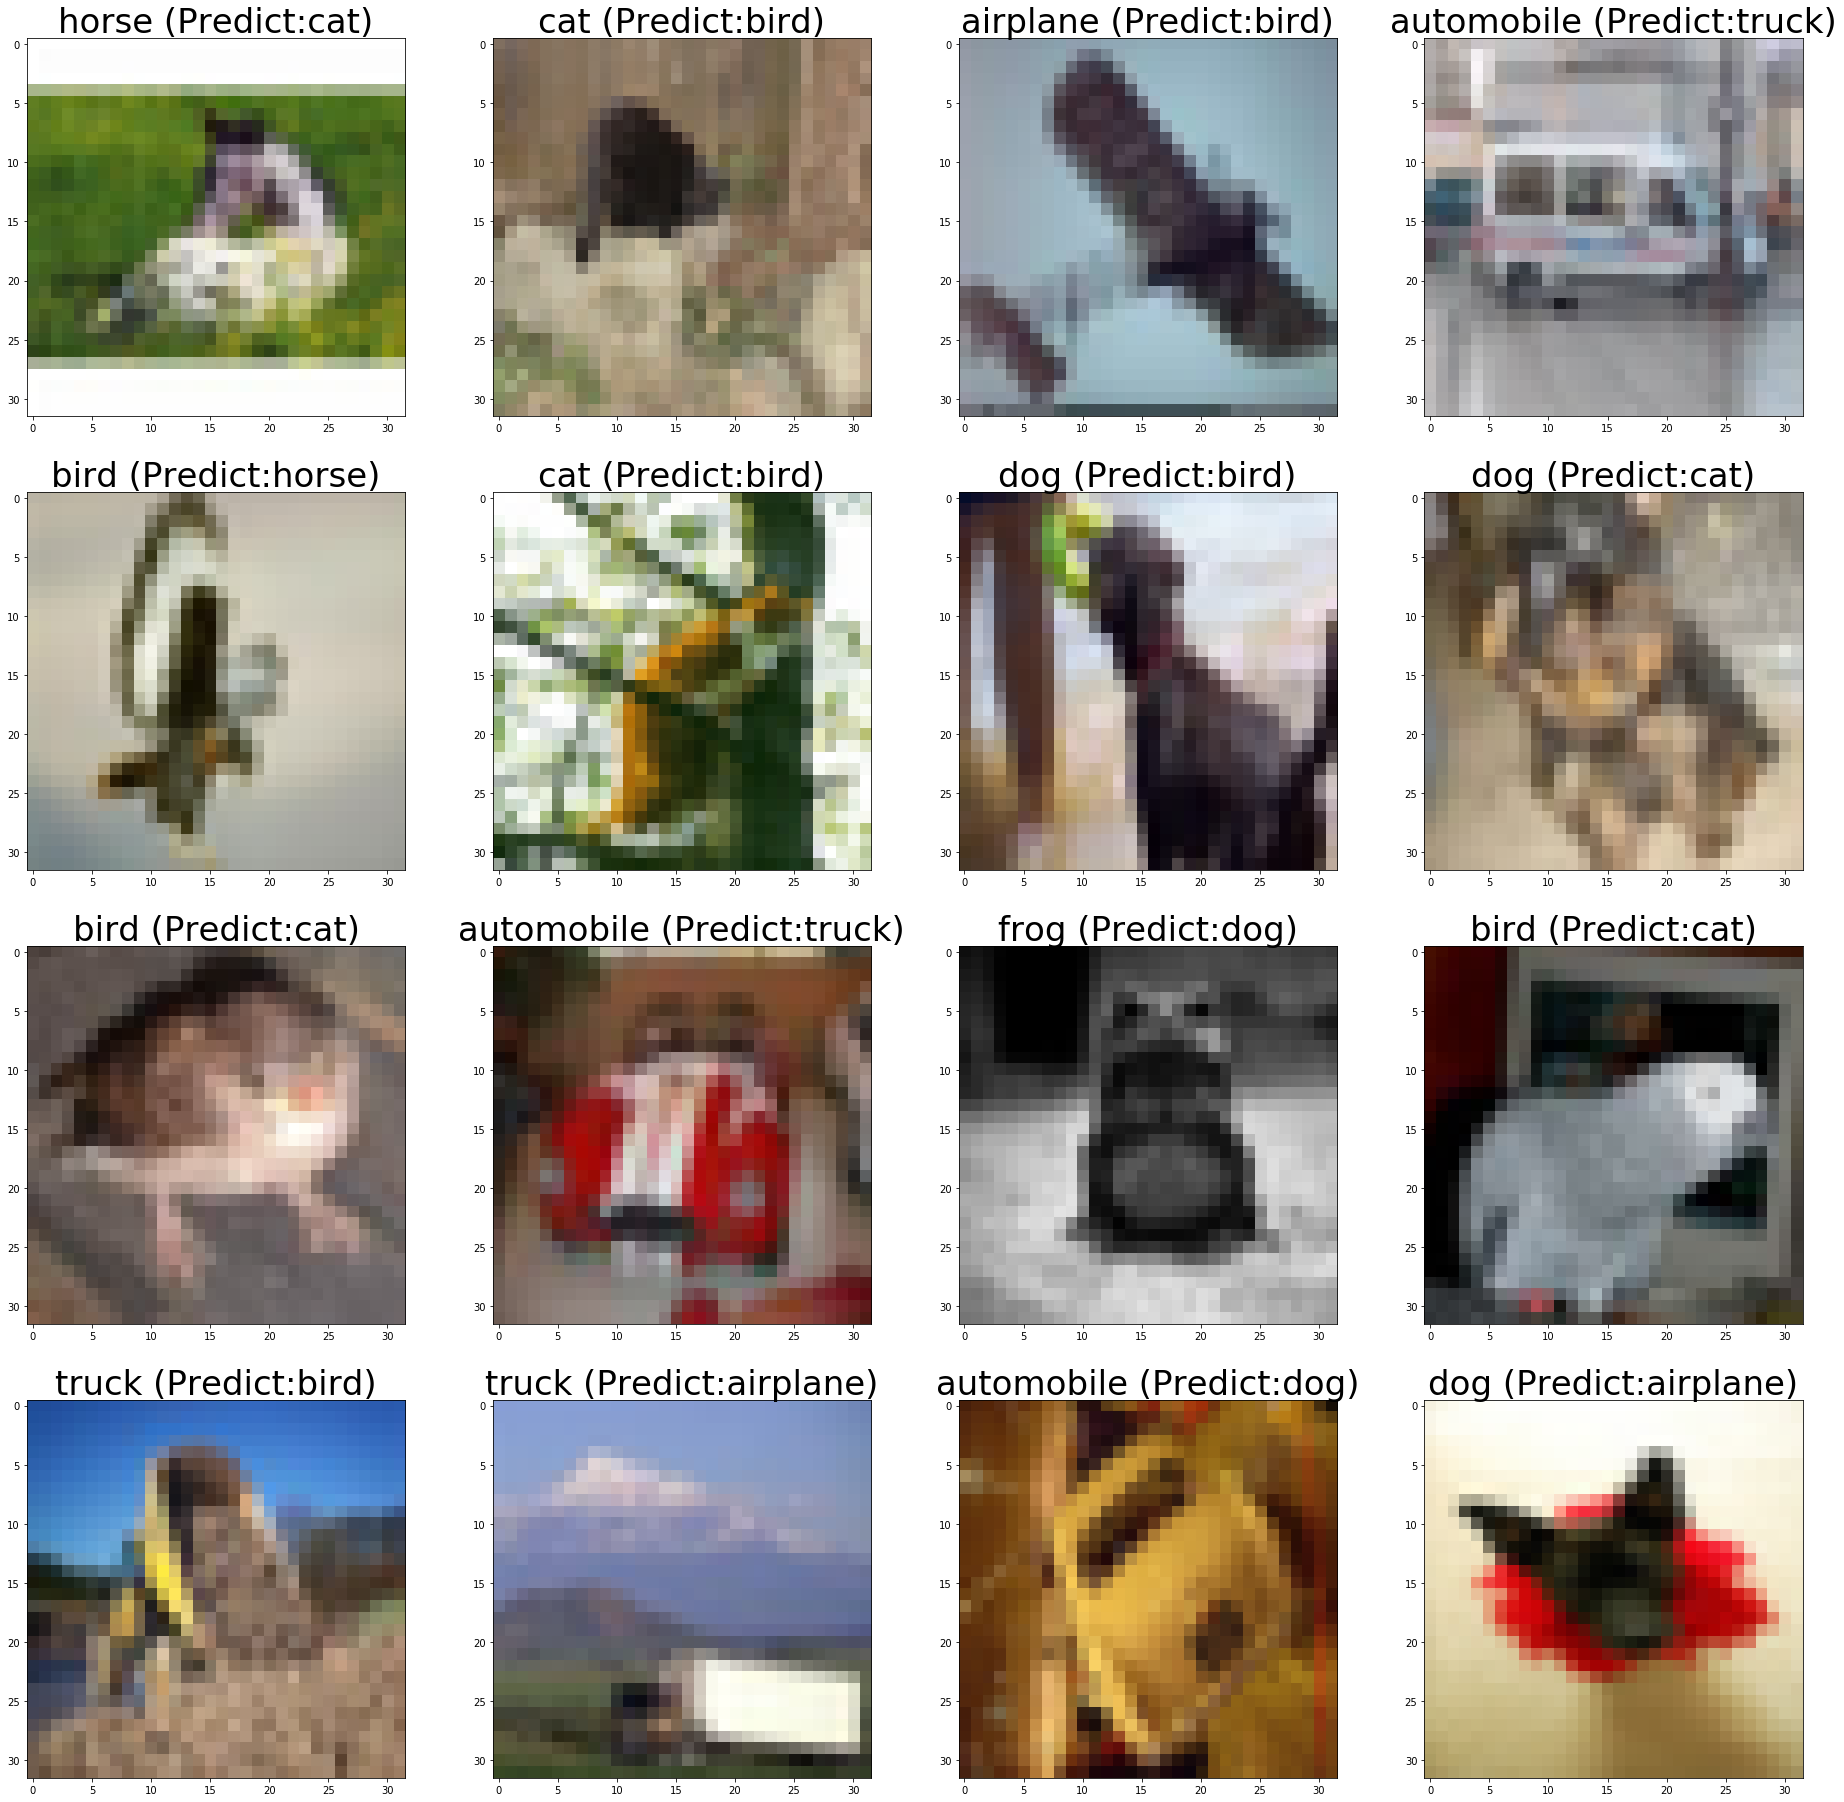

In [41]:
import matplotlib.pyplot as plt

nrows=4
ncols=4
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(32, 32))
cifar = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[ii, jj]
        iplt.set_title(  cifar[y_val1[error_list[ii*ncols + jj]]] + " (Predict:" + cifar[predicts[error_list[ii*ncols + jj]]] + ")" , fontsize=34, y=1)
        
        img_array = x_val1[error_list[ii*ncols + jj]]
        iplt.imshow(img_array)